In [1]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



2024-12-27 12:43:08.595302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2024-12-27 12:43:08.595929: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2024-12-27 12:43:08.596346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2024-12-27 12:43:08.596725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cufft64_10.dll'; dlerror: cufft64_10.dll not found
2024-12-27 12:43:08.597128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'curand64_10.dll'; dlerror: curand64_10.dll not found
2024-12-27 12:43:08.597513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

[]
Num GPUs Available:  0


In [3]:
# Configurar para usar solo la memoria necesaria
# physical_devices = tf.config.list_physical_devices('GPU')
# if physical_devices:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
#     print('done')

In [4]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [5]:
P0_exp=df2.iloc[:, -5:]
P1_exp=df2.iloc[:, 3:9]
P2_exp=df2.iloc[:, 9:14]
P3_exp=df2.iloc[:, [15,19,20]]


P0_exp, P1_exp, P2_exp, P3_exp


(0        H7      H8      H9     H10     H11
 0    0.0921   0.092   0.093  0.0927   0.093
 1    0.0921  0.0921  0.0931  0.0932  0.0925
 2    0.0922  0.0923  0.0932  0.0932  0.0927
 3    0.0928  0.0926  0.0936  0.0937   0.093
 4    0.0933  0.0933  0.0943  0.0944  0.0938
 ..      ...     ...     ...     ...     ...
 337  1.0018  0.9769  0.9848  0.9871  0.9972
 338  1.0017    0.98  0.9857  0.9868  0.9976
 339  1.0009  0.9758  0.9833  0.9846  0.9963
 340  1.0004  0.9763  0.9843  0.9845  0.9981
 341  1.0014  0.9772  0.9853  0.9843  0.9956
 
 [342 rows x 5 columns],
 0        A1      A2      A3      A4      A5      A6
 0    0.0929  0.0971  0.0948  0.0961  0.0939  0.0934
 1    0.0925  0.0962  0.0946  0.0953  0.0935  0.0931
 2    0.0926  0.0962   0.095  0.0954  0.0936  0.0932
 3    0.0928  0.0981  0.0949  0.0956  0.0937  0.0934
 4    0.0933  0.0985  0.0953   0.096  0.0942  0.0939
 ..      ...     ...     ...     ...     ...     ...
 337  0.5954  0.6453  0.6513  0.6593  0.6599  0.6576
 338  0.5

In [6]:
P2_exp.shape

(342, 5)

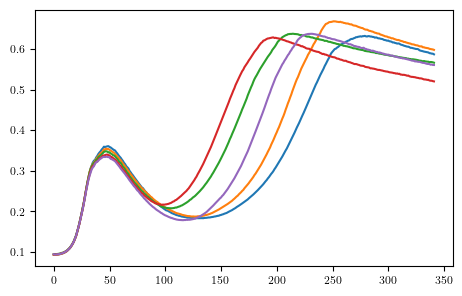

In [7]:
plt.plot(P2_exp)

In [8]:
P1_exp.shape

(342, 6)

In [9]:
c=-1
P_exp=np.hstack((P0_exp,P1_exp,P2_exp,P3_exp))
T_exp=np.array(df2['Time [s]'])

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
n=np.array([P0_exp.shape[1],P1_exp.shape[1],P2_exp.shape[1],P3_exp.shape[1],])
A=np.array([0, 1.25, 2.50, 3.75])
A=A/np.max(A)
N_exp,T_max, T_exp.shape, P_exp.shape, 342*23

(19, 231399.5, (342,), (342, 19), 7866)

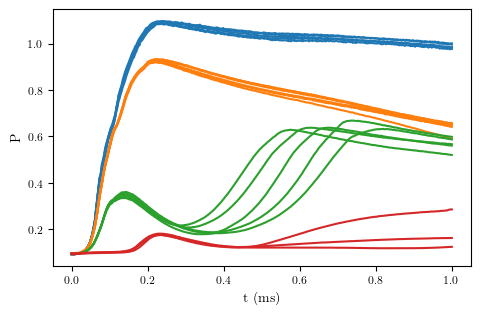

In [10]:
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)

plt.xlabel('t (ms)')
plt.ylabel('P')
plt.show()

In [11]:
N_f = 1000 # Number of residual point
N_d = 1500 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
Xa_star=[]
P0_star=np.empty((0, 1))
X_star = np.empty((0, 3))
for i in range(len(A)):
    P0=P_exp[0:1, np.sum(n[:i]):np.sum(n[:i+1])]
    P0_star=np.concatenate((P0_star,P0.T))
    T_meshgrid, P0_meshgrid, A_meshgrid = np.meshgrid(T_exp, P0, A[i])
    x=np.hstack((T_meshgrid.flatten()[:,None], P0_meshgrid.flatten()[:,None], A_meshgrid.flatten()[:,None]))
    Xa_star += [x]
    X_star=np.vstack((X_star,x))


u_star=np.hstack((P_star,X_star[:,1:2]))

In [12]:
# T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = X_star.min(0)
lb[1]=lb[1]
ub = X_star.max(0) 
ub[1]=ub[1]


# Initial Condition
xx0 = X_star[::len(T_exp)]
uu0 = P_star[::len(T_exp)]

xx1= np.hstack((np.ones(len(P0_star)).reshape([-1,1]), P0_star.reshape([-1,1]), xx0[...,2:3]))

xx01=np.vstack((xx0, xx1))
uu01=np.array([1]*N_exp+[0]*N_exp).reshape([-1,1])

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu0), replace=False)
xxd = X_star[idx]
uud = P_star[idx]

X_u_train = np.concatenate((xx0,xxd))
P_train = np.concatenate((uu0,uud))

X_f_train = lb + (ub-lb)*lhs(3, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
P_train_tf =   tf.convert_to_tensor(P_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)
xx01_tf = tf.convert_to_tensor(xx01, dtype=tf.float32)
uu01_tf = tf.convert_to_tensor(uu01, dtype=tf.float32)

2024-12-27 12:43:10.131595: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


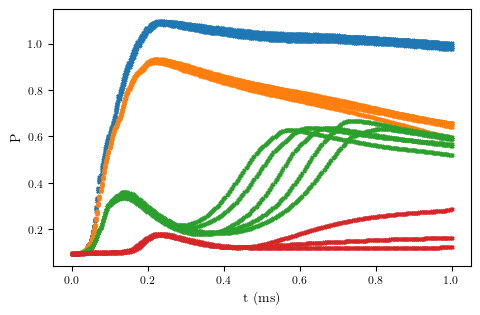

In [13]:
L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=5,  color=color)


plt.xlabel('t (ms)')
plt.ylabel('P')
plt.show()

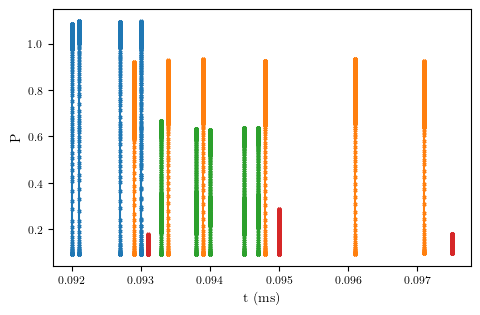

In [14]:
L_exp=len(P_exp[:,1])
for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        plt.plot(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,1],P_exp[:, (i + np.sum(n[:k]))], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,1],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', color=color, s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

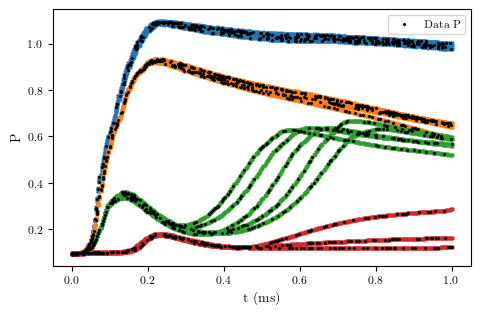

In [15]:
L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=5,  color=color)


plt.xlabel('t (ms)')
plt.ylabel('P')

plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()

# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()

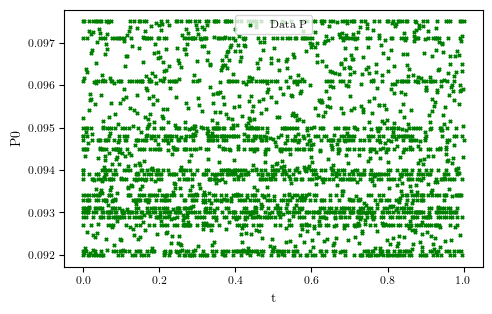

In [16]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,1], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
plt.ylabel('P0')
# #plt.savefig('figures/P_phi.pdf')
plt.show()

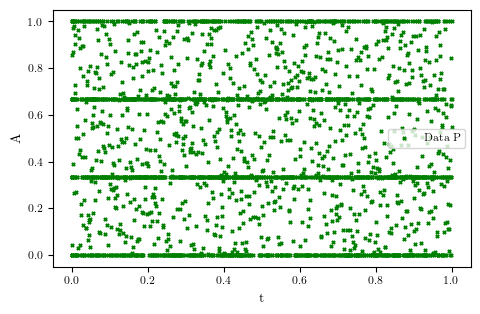

In [17]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,2], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
plt.ylabel('A')
# #plt.savefig('figures/P_phi.pdf')
plt.show()

In [18]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    # A = 2.0*(X - lb)/(ub - lb) - 1.0
    A=X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 


def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r+N_b, 2]), dtype=tf.float32)
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp*2), (N_exp*2, -1))) 
    return alpha_r, alpha_b, alpha_0


#@tf.function(jit_compile=True)
@tf.function()
def net_f(X_f, W_p, b_p, W_phi, b_phi):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([X_f])
        u=net(X_f, W_p, b_p)

        p=tf.exp(u)
       
        # m=tf.exp(lnv[0:1])
        a=X_f[...,2:3]
        t=X_f[...,0:1]
        # phi_s=tf.exp(net(tf.concat([p, s, a],1), W_a, b_a))
        
        phi=net(tf.concat([p, t, a],1), W_phi, b_phi)

        # phi=tf.exp(net(s, W_phi, b_phi))



    p_t = tape1.gradient(p, X_f)[...,0:1]

    f_p = p_t - phi*p
    
    return f_p




#@tf.function()
# @tf.function()
def train_step(W_p, b_p,  W_phi, b_phi,  X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, opt):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, lambda_b, lambda_r, lambda_0])
        u_nn = net(X_u_train_tf, W_p, b_p) 
        lnp=u_nn[:,0:1]
        p_nn=tf.exp(lnp)
        f_p = net_f(X_f_train_tf, W_p, b_p, W_phi, b_phi)

        u_00 = net(xx01_tf, W_p, b_p) 
        lns_0=u_00[:,1:2]
        s_00=tf.exp(lns_0)


        loss_p = tf.square(lambda_b*(p_nn - P_train_tf))
        loss_0s = tf.square(lambda_0*(s_00 - uu01_tf))
        loss_fp = tf.square(lambda_r[:,0:1]*f_p) 


        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_0s)

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
    # grads_a = tape.gradient(loss, train_vars(W_a, b_a))

    # grads_lnv = tape.gradient(loss, lnv)
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    grads_0 = tape.gradient(loss, lambda_0)


    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
    # opt.apply_gradients(zip(grads_a, train_vars(W_a, b_a)))

    # opt.apply_gradients(zip([grads_lnv], [lnv]))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    opt.apply_gradients(zip([-grads_0], [lambda_0]))

   
    return loss, tf.reduce_mean(tf.square((p_nn - P_train_tf))), tf.reduce_mean(tf.square(f_p))


layers = [3, 20, 20, 1]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

# layers = [3, 20, 20, 1]

# W_a = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
# b_a = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [3, 30, 30, 1]
L = len(layers)

W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lnv = tf.Variable(tf.reshape(tf.repeat(1.0, 1), (1, -1)), dtype=tf.float32) 
lambda_r, lambda_b, lambda_0 = loss_weight(N_f, N_d)



In [19]:
# def train_dynamic_step( W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv, opt):
#     with tf.GradientTape(persistent=True) as tape:
#         tape.watch([W_phi, b_phi, W_a, b_a, lambda_r, lnv])

#         f_p, f_s = net_f(X_f_train_tf, W_p, b_p, W_phi, b_phi, W_a, b_a, lnv)

#         loss_fp = tf.square(lambda_r[0:1]*f_p) 
#         loss_fs = tf.square(lambda_r[1:2]*f_s) 


#         loss =  tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs)


#     grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
#     grads_a = tape.gradient(loss, train_vars(W_a, b_a))

#     # grads_lnv = tape.gradient(loss, lnv)
#     grads_u = tape.gradient(loss, lambda_r)



#     opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
#     opt.apply_gradients(zip(grads_a, train_vars(W_a, b_a)))

#     # opt.apply_gradients(zip([grads_lnv], [lnv]))
#     opt.apply_gradients(zip([-grads_u], [lambda_r]))

   
#     return loss, 0, tf.reduce_mean(tf.square(f_p)), tf.reduce_mean(tf.square(f_s))

In [20]:
lr = 5e-3




optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/5)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/10)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
it=0
loss = []
loss_d = []
loss_fisp = []
loss_fiss = []
loss_reg=[]
# loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p,  W_phi, b_phi,  X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p,  W_phi, b_phi,  X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer2)
# train_step_3 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer3)
# train_step_3 = tf.function(train_dynamic_step).get_concrete_function(W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv, optimizer2)


In [21]:
Nmax=1*10**4
# Nmax=2*10**5



while it <= Nmax:
    # if it<5*10**4:
    loss_, loss_p, loss_fp = train_step_1(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    # elif it<10*10**4:
    #     loss_, loss_p, loss_fp, loss_fs = train_step_2(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    # else:
    #     loss_, loss_p, loss_fp, loss_fs = train_step_3(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)

    #     loss_, loss_p, loss_fp, loss_fs = train_step_3(W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp.append(loss_fp)
    # loss_fiss.append(loss_fs)
    # loss_fisa.append(loss_fa)



    if it % 10 == 0:

        print(f"Iteration is: {it}")
        # print(f"Total loss is: {loss_}")
        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_fp}")
        # print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    it+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Data loss is: 0.10759899765253067
Physicial loss of p is: 0.00573744298890233
Iteration is: 10
Data loss is: 0.04133874550461769
Physicial loss of p is: 0.024397240951657295
Iteration is: 20
Data loss is: 0.041978128254413605
Physicial loss of p is: 0.026941750198602676
Iteration is: 30
Data loss is: 0.040146831423044205
Physicial loss of p is: 0.004602950066328049
Iteration is: 40
Data loss is: 0.03807774931192398
Physicial loss of p is: 0.0008868981385603547
Iteration is: 50
Data loss is: 0.03766007348895073
Physicial loss of p is: 0.000924993772059679
Iteration is: 60
Data loss is: 0.03740156441926956
Physicial loss of p is: 0.00045522040454670787
Iteration is: 70
Data loss is: 0.0369572751224041
Physicial loss of p is: 0.0006704461411572993
Iteration is: 80
Data loss is: 0.03630993515253067
Physicial loss of p is: 0.00042167273932136595
Iteration is: 90
Data loss is: 0.035266976803541183
Physicial loss of p is: 0.0006306420546025038
Iteration is: 100
Data loss is: 0

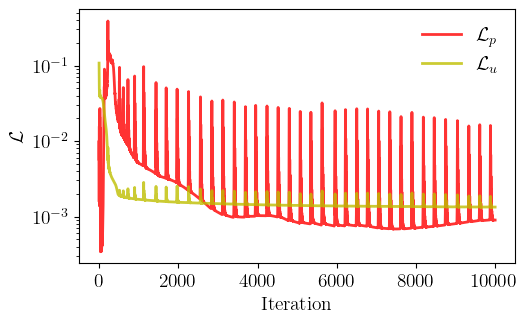

In [22]:
Nmax=len(loss)
ep = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]

loss_phip_list = [loss_fisp[i].numpy() for i in range(0,Nmax)]
# loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]



plt.semilogy(ep, np.asarray(loss_phip_list), 'r-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_p$')    
# plt.semilogy(ep, np.asarray(loss_phis_list), 'g-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_s$')   
plt.semilogy(ep, np.asarray(loss_data_list), 'y-', linewidth = 2, alpha=0.8, label = '$\mathcal{L}_u$')  


# plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(0.77, 0.4))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\mathcal{L}$', fontsize=14)    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/600/Loss_split.png')
plt.savefig('../Img/600/Loss_split.pdf')
plt.savefig('../Img/600/Loss_split.svg')
plt.show()

In [23]:
# lnv[0], tf.exp(lnv[0]), #lnv[1], tf.exp(lnv[1])

In [24]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)  
# A_star_tf = tf.convert_to_tensor(A, dtype=tf.float32)    

u_pred = predict(X_star_tf, W_p, b_p)


p=tf.exp(u_pred)

# m=tf.exp(lnv[0:1])
a=X_star_tf[...,2:3]
t=X_star_tf[...,0:1]
# phi_s=tf.exp(net(tf.concat([p, s, a],1), W_a, b_a))

phi=predict(tf.concat([p, t, a],1), W_phi, b_phi)




In [25]:
X_star_tf.shape, p.shape

(TensorShape([6498, 3]), TensorShape([6498, 1]))

In [26]:
X_star_tf[...,2:3]

<tf.Tensor: shape=(6498, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)>

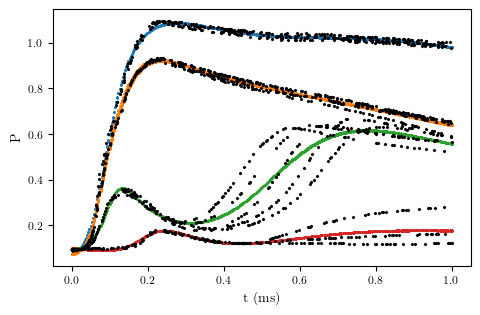

In [27]:


L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],p[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=1,  color=color, label='Prediction P')
plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')



plt.xlabel('t (ms)')
plt.ylabel('P')


# plt.legend()

# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()

In [28]:


# L_exp=len(P_exp[:,1])
# colors = plt.cm.tab10.colors

# for k, j in enumerate(n):
#     # Seleccionar el color correspondiente de la paleta
#     color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
#     for i in range(j):
#         # Aquí puedes pasar el color seleccionado en cada iteración
#         # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
#         plt.scatter(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],s[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=1,  color=color, label='Prediction P')



# plt.xlabel('t (ms)')
# plt.ylabel('S')
# # plt.yscale('log')

# # plt.legend()

# # plt.ylabel('P')
# # #plt.savefig('figures/P_phi.pdf')
# plt.show()

In [29]:


# L_exp=len(P_exp[:,1])
# colors = plt.cm.tab10.colors

# for k, j in enumerate(n):
#     # Seleccionar el color correspondiente de la paleta
#     color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
#     for i in range(j):
#         # Aquí puedes pasar el color seleccionado en cada iteración
#         # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
#         plt.scatter(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,2],l[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', color=color, label='Prediction P')



# plt.xlabel('A')
# plt.ylabel('death rate')
# # plt.yscale('log')

# # plt.legend()

# # plt.ylabel('P')
# # #plt.savefig('figures/P_phi.pdf')
# plt.show()

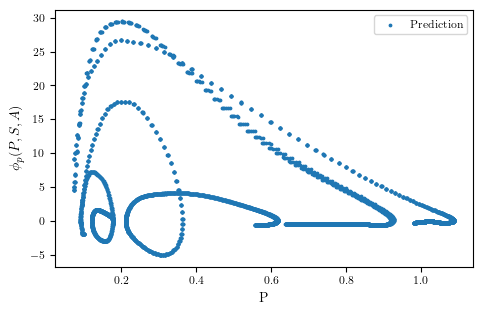

In [30]:
plt.scatter(p, phi, s=3, label='Prediction')
# plt.scatter(s, phi, s=3, label='Prediction')

# plt.plot(u_pred[:,1:2], phi_pred, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('P')
plt.ylabel('$\phi_p(P,S,A)$')
# #plt.savefig('figures/phi.pdf')
plt.show()

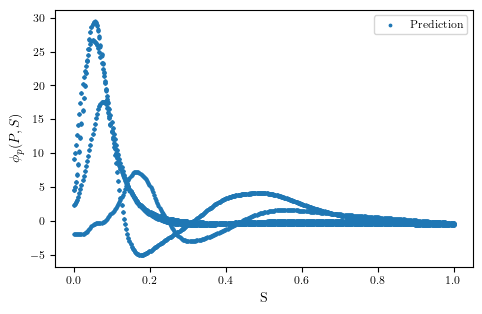

In [31]:
plt.scatter(t, phi, s=3, label='Prediction')

# plt.scatter(s, phi_s, s=3, label='Prediction')
# 
# plt.scatter(a, phi_s, s=3, label='Prediction')


# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('S')
plt.ylabel('$\phi_p(P,S)$')
# #plt.savefig('figures/phi.pdf')
plt.show()

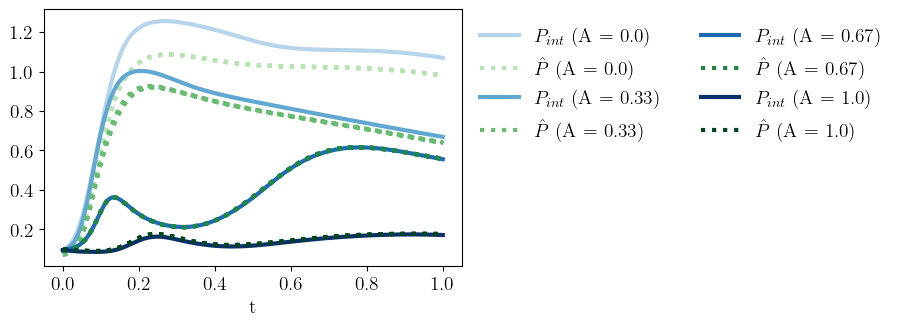

In [32]:
Nt=1000

colors_p = plt.cm.Blues(np.linspace(0.3, 1, len(A)))
colors_s = plt.cm.Oranges(np.linspace(0.3, 1, len(A)))
colors_t = plt.cm.Greens(np.linspace(0.3, 1, len(A)))


for idx, a_ in enumerate(A):

    T_int=np.zeros(Nt)
    P_int=np.zeros(Nt)
    S_int=np.zeros(Nt)


    dt=0.001

    T_int[0]=0
    P_int[0]=np.mean(P0) #Initial conditions

    for i in range(1,Nt):

        PTA=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_int[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PHI_S=tf.exp(net(PSA, W_a, b_a))
        
        PHI=net(PTA, W_phi, b_phi)
        # REVISAAAAAR
        # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P_int[i]=P_int[i-1]+P_int[i-1]*PHI*dt
        # S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*PHI_S*dt
        T_int[i]=T_int[i-1]+dt


    plt.plot(T_int, P_int, linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
    # plt.plot(T_int, S_int,linewidth=3, linestyle='--', label='$S_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_s[idx])

    i=0
    plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx], label='$\hat{P}$'+f' (A = {np.round(A[idx], 2)})')

    for i in range(1,n[idx]):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx])




plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('t', fontsize=14)
# plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.tight_layout()
plt.savefig('../Img/600/Result_int.png')
plt.savefig('../Img/600/Result_int.pdf')
plt.savefig('../Img/600/Result_int.svg')
plt.show()

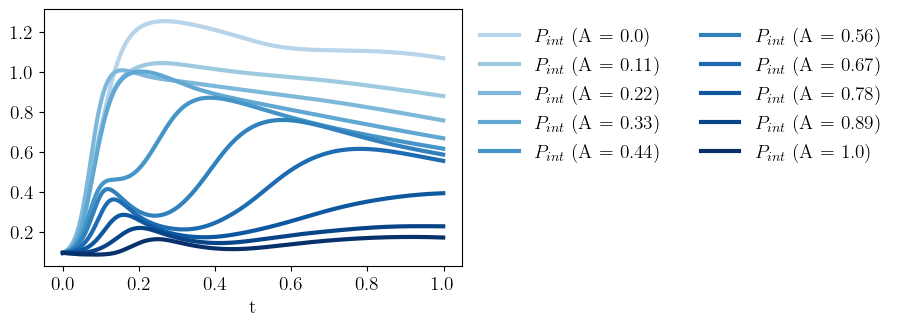

In [33]:
Nt=1000
A_int=np.linspace(0,1,10)
colors_p = plt.cm.Blues(np.linspace(0.3, 1, len(A_int)))
colors_s = plt.cm.Oranges(np.linspace(0.3, 1, len(A_int)))
for idx, a_ in enumerate(A_int):

    T_int=np.zeros(Nt)
    P_int=np.zeros(Nt)
    S_int=np.zeros(Nt)


    dt=0.001

    T_int[0]=0
    P_int[0]=np.mean(P0) #Initial conditions

    for i in range(1,Nt):

        PTA=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_int[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PHI_S=tf.exp(net(PSA, W_a, b_a))
        
        PHI=net(PTA, W_phi, b_phi)
        # REVISAAAAAR
        # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P_int[i]=P_int[i-1]+P_int[i-1]*PHI*dt
        # S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*PHI_S*dt
        T_int[i]=T_int[i-1]+dt


    plt.plot(T_int, P_int, linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
    # plt.plot(T_int, S_int,linewidth=3, linestyle='--', label='$S_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_s[idx])

    # i=0
    # plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx], label='$\hat{P}$'+f' (A = {np.round(A_int[idx], 2)})')

    # for i in range(1,n[idx]):
    #     # Aquí puedes pasar el color seleccionado en cada iteración
    #     # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
    #     plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx])




plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('t', fontsize=14)
# plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.tight_layout()
plt.savefig('../Img/600/Result_int_2.png')
plt.savefig('../Img/600/Result_int_2.pdf')
plt.savefig('../Img/600/Result_int_2.svg')
plt.show()

# Symbolic Regresion

In [320]:
A_symb=np.linspace(0,1,4)
T_symb=np.linspace(0,1,500)
P0=np.mean(P_exp[::L_exp])

In [321]:
X_star_symb = np.empty((0, 3))
for i in range(len(A_symb)):
    T_meshgrid, P0_meshgrid, A_meshgrid = np.meshgrid(T_symb, P0, A_symb[i])
    x=np.hstack((T_meshgrid.flatten()[:,None], P0_meshgrid.flatten()[:,None], A_meshgrid.flatten()[:,None]))
    X_star_symb=np.vstack((X_star_symb,x))

In [322]:
X_star_symb_tf=tf.convert_to_tensor(X_star_symb, dtype=tf.float32)  
u_pred = predict(X_star_symb_tf, W_p, b_p)

# ## Evaluating unknown function
p_symb=tf.exp(u_pred)
# s_symb=tf.exp(lns)
a_symb=X_star_symb_tf[...,2:3]
t_symb=X_star_symb_tf[...,0:1]

# phi_s=tf.exp(net(tf.concat([p_symb, s_symb, a_symb],1), W_a, b_a))
phi=net(tf.concat([p_symb, t_symb, a_symb],1), W_phi, b_phi)



C:\Users\julia\AppData\Local\Temp\ipykernel_37580\3870088709.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición


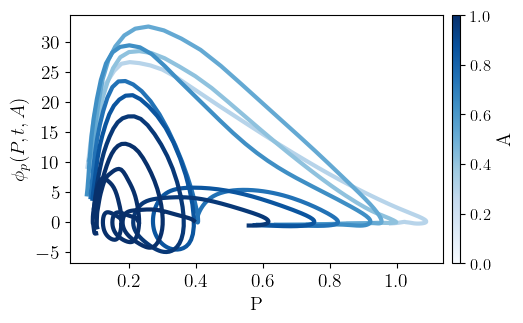

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

# Configuración de la colormap
norm = plt.Normalize(vmin=min(A_symb), vmax=max(A_symb))  # Normaliza los valores de A_symb
cmap = cm.Blues  # Puedes cambiar "viridis" por otro mapa de colores
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para asociar el colorbar

# Plot con color asociado a A_symb
for idx, a_ in enumerate(A_symb):
    c = len(T_symb) * idx
    d = len(T_symb) * (idx + 1)
    plt.plot(
        p_symb[c:d],
        phi[c:d],
        linewidth=3,
        linestyle='-',
        color=cmap(norm(a_+0.3))  # Asocia el color correspondiente a a_
    )

# Añade la colorbar
cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición
cbar.set_label('A', fontsize=14)  # Etiqueta de la colorbar
cbar.ax.tick_params(labelsize=12)

# Ejes y configuración
plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi_p(P,t,A)$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig('../Img/600/Phi_p_p.png')
plt.savefig('../Img/600/Phi_p_p.pdf')
plt.savefig('../Img/600/Phi_p_p.svg')
plt.show()


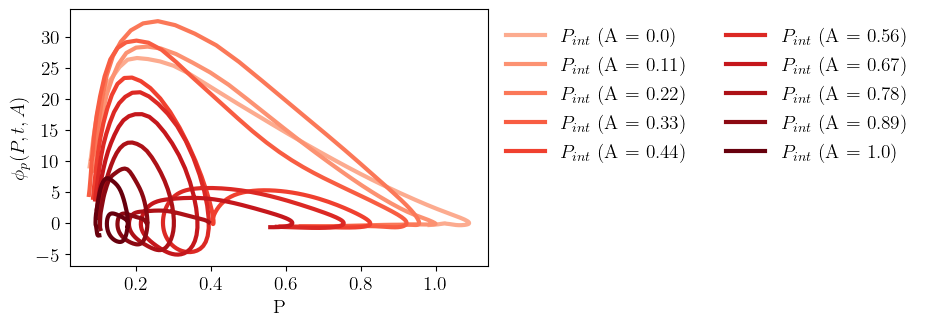

In [80]:
for idx, a_ in enumerate(A_symb):
    c=len(T_symb)*idx
    d=len(T_symb)*(idx+1)
    plt.plot( p_symb[c:d], phi[c:d], linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
    # plt.scatter( s_symb[c:d], phi[c:d], s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi_p(P,t,A)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.tight_layout()
# plt.savefig('../Img/600/Phi_p_p.png')
# plt.savefig('../Img/600/Phi_p_p.pdf')
# plt.savefig('../Img/600/Phi_p_p.svg')
plt.show()

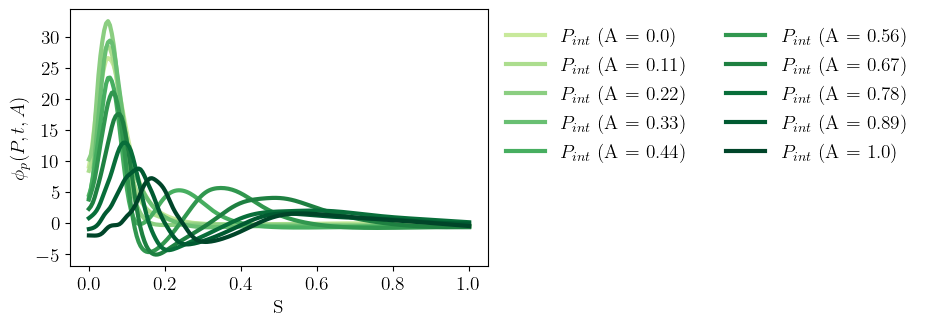

In [81]:
for idx, a_ in enumerate(A_symb):
    c=len(T_symb)*idx
    d=len(T_symb)*(idx+1)
    plt.plot( t_symb[c:d], phi[c:d], linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_s[idx])
    # plt.scatter( s_symb[c:d], phi[c:d], s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('S', fontsize=14)
plt.ylabel('$\phi_p(P,t,A)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.tight_layout()
# plt.savefig('../Img/600/Phi_p_s.png')
# plt.savefig('../Img/600/Phi_p_s.pdf')
# plt.savefig('../Img/600/Phi_p_s.svg')
plt.show()

C:\Users\julia\AppData\Local\Temp\ipykernel_37580\1255916143.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición


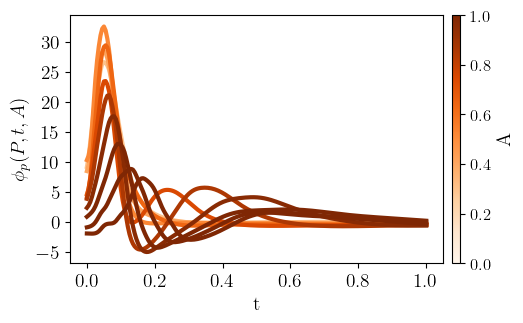

In [82]:

# Configuración de la colormap
norm = plt.Normalize(vmin=min(A_symb), vmax=max(A_symb))  # Normaliza los valores de A_symb
cmap = cm.Oranges  # Puedes cambiar "viridis" por otro mapa de colores
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para asociar el colorbar

# Plot con color asociado a A_symb
for idx, a_ in enumerate(A_symb):
    c = len(T_symb) * idx
    d = len(T_symb) * (idx + 1)
    plt.plot(
        t_symb[c:d],
        phi[c:d],
        linewidth=3,
        linestyle='-',
        color=cmap(norm(a_+0.3))  # Asocia el color correspondiente a a_
    )

# Añade la colorbar
cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición
cbar.set_label('A', fontsize=14)  # Etiqueta de la colorbar
cbar.ax.tick_params(labelsize=12)

# Ejes y configuración
plt.xlabel('t', fontsize=14)
plt.ylabel('$\phi_p(P,t,A)$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig('../Img/600/Phi_p_s.png')
plt.savefig('../Img/600/Phi_p_s.pdf')
plt.savefig('../Img/600/Phi_p_s.svg')
plt.show()


In [41]:

# # Configuración de la colormap
# norm = plt.Normalize(vmin=min(A_symb), vmax=max(A_symb))  # Normaliza los valores de A_symb
# cmap = cm.Blues  # Puedes cambiar "viridis" por otro mapa de colores
# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # Necesario para asociar el colorbar

# # Plot con color asociado a A_symb
# for idx, a_ in enumerate(A_symb):
#     c = len(T_symb) * idx
#     d = len(T_symb) * (idx + 1)
#     plt.plot(
#         p_symb[c:d],
#         phi_s[c:d],
#         linewidth=3,
#         linestyle='-',
#         color=cmap(norm(a_+0.3))  # Asocia el color correspondiente a a_
#     )

# # Añade la colorbar
# cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición
# cbar.set_label('A', fontsize=14)  # Etiqueta de la colorbar
# cbar.ax.tick_params(labelsize=12)

# # Ejes y configuración
# plt.xlabel('P', fontsize=14)
# plt.ylabel('$\phi_s(P,S,A)$', fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.tight_layout()

# plt.savefig('../Img/600/Phi_s_p.png')
# plt.savefig('../Img/600/Phi_s_p.pdf')
# plt.savefig('../Img/600/Phi_s_p.svg')
# plt.show()


In [42]:

# # Configuración de la colormap
# norm = plt.Normalize(vmin=min(A_symb), vmax=max(A_symb))  # Normaliza los valores de A_symb
# cmap = cm.Oranges  # Puedes cambiar "viridis" por otro mapa de colores
# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # Necesario para asociar el colorbar

# # Plot con color asociado a A_symb
# for idx, a_ in enumerate(A_symb):
#     c = len(T_symb) * idx
#     d = len(T_symb) * (idx + 1)
#     plt.plot(
#         s_symb[c:d],
#         phi_s[c:d],
#         linewidth=3,
#         linestyle='-',
#         color=cmap(norm(a_+0.3))  # Asocia el color correspondiente a a_
#     )

# # Añade la colorbar
# cbar = plt.colorbar(sm, aspect=30, pad=0.02)  # Ajusta el tamaño y posición
# cbar.set_label('A', fontsize=14)  # Etiqueta de la colorbar
# cbar.ax.tick_params(labelsize=12)

# # Ejes y configuración
# plt.xlabel('S', fontsize=14)
# plt.ylabel('$\phi_s(P,S,A)$', fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.tight_layout()

# plt.savefig('../Img/600/Phi_s_s.png')
# plt.savefig('../Img/600/Phi_s_s.pdf')
# plt.savefig('../Img/600/Phi_s_s.svg')
# plt.show()


In [43]:
# c=0
# d=-1
# plt.scatter( p_symb[c:d], phi_s[c:d], s=2, label='Prediction P')
# plt.scatter( s_symb[c:d], phi_s[c:d], s=2, label='Prediction S')
# # plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


# plt.legend()
# plt.xlabel('t')
# # plt.ylabel('P')
# # #plt.savefig('figures/P_phi.pdf')
# plt.show()
# X_star_tf[c:d][0], X_star_tf[c:d][-1]

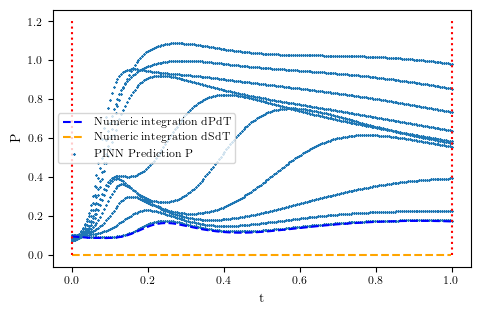

In [44]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')




plt.scatter(X_star_symb_tf[:,0], p_symb, marker='x', s=1,  label='PINN Prediction P')
# plt.scatter(X_star_symb_tf[:,0], s_symb, marker='x', s=1,  label='PINN Prediction S')


plt.vlines(X_star_symb_tf[c:d][:,0][0],0,1.2, color='red', linestyle=':')
plt.vlines(X_star_symb_tf[c:d][:,0][-1],0,1.2, color='red', linestyle=':')


plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [45]:
# Create and train the PySR model
model_phi= PySRRegressor(
    niterations=200,
    # binary_operators=["+", "*", "inv(x, y) = x/(x + y)", "^"],
    binary_operators=["+", "*", "inv(x, y) = x/(x + y)"],

    # unary_operators=["inv(x) = 1/x"],
    # unary_operators=["exp","inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x, y: x/(x+y),},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    complexity_of_variables=1,
    complexity_of_constants=1,
    complexity_of_operators={"inv": 3},
    parsimony=0.000001,
    # select_k_features=2,
    # constraints={"^": (3, 1)},
    maxsize=40,
    progress=True  # Show progress during training
)

In [46]:
# p1s=tf.concat([p1[c:d], s[c:d]], axis=1)

min_cols_phi_p= tf.math.reduce_min(phi, axis=0)
max_cols_phi_p= tf.math.reduce_max(phi, axis=0)

phi_p_scaled = (phi-min_cols_phi_p)/(max_cols_phi_p-min_cols_phi_p)

# min_cols_phi_s= tf.math.reduce_min(phi_s, axis=0)
# max_cols_phi_s= tf.math.reduce_max(phi_s, axis=0)

# phi_s_scaled = (phi_s-min_cols_phi_s)/(max_cols_phi_s-min_cols_phi_s)

PTA_tf=tf.concat([p_symb, t_symb, a_symb],1)
# PSA_tf=tf.concat([s_symb, a_symb],1)
# PHI_SCALED_tf=tf.concat([phi_p_scaled, phi_s_scaled],1)

In [47]:
model_phi.fit(PTA_tf,phi_p_scaled)
print(model_phi)


c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 5.460e+04
Head worker occupation: 24.3%
Progress: 134 / 3000 total iterations (4.467%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.706e-01  1.594e+01  y = -0.49026
3           1.995e-02  1.581e+00  y = 0.42549 * 0.42549
5           1.570e-02  1.196e-01  y = 0.29329 + (-0.2245 * x₁)
7           1.264e-02  1.085e-01  y = inv(0.20349, x₁) * 0.48441
9           1.075e-02  8.090e-02  y = inv(0.32838, x₁ + (x₀ + x₂))
11          9.152e-03  8.049e-02  y = inv(0.068842, (0.23909 * x₂) + (x₁ * x₀))
13          8.346e-03  4.608e-02  y = inv(0.063477, ((x₂ * 0.32973) * x₂) + (x₁ * x₀))
15          8.233e-03  6.811e-03  y = inv(0.072549, ((x₂ * x₂) * 0.39932) + ((x₁ * x₀) + 0.00362...
                                  36))
17          8.084e-03  9.156e-03  y = inv(0.072549, (x₂ * (0.39932 * x₂)) + ((0.072549 + (x₁ * x...
                  

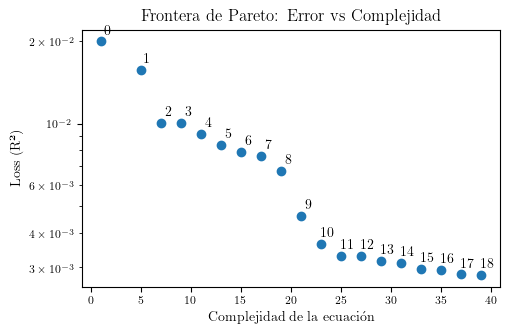

In [48]:
# Extraer las métricas de las ecuaciones
equations_df = model_phi.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.yscale('log')
plt.show()

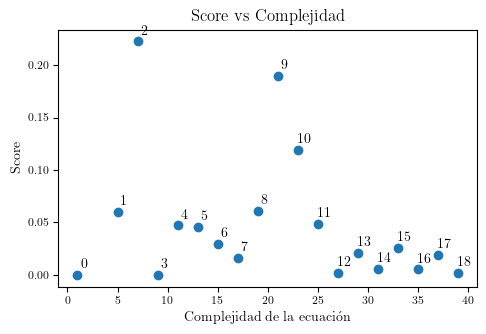

In [49]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [50]:
equations_df

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.019945,0.000000,0.18104254,0.181042540000000,PySRFunction(X=>0.181042540000000)
1,5,0.015703,0.059788,0.29329398 + (-0.22450334 * x1),0.29329398 - 0.22450334*x1,PySRFunction(X=>0.29329398 - 0.22450334*x1)
2,7,0.010063,0.222484,0.7643648 + (-0.5570814 * (x0 + x2)),0.7643648 - 0.5570814*(x0 + x2),PySRFunction(X=>0.7643648 - 0.5570814*(x0 + x2))
3,9,0.010058,0.000273,0.7643648 + (-0.5570814 * ((x0 * 1.0016551) + ...,0.7643648 - 0.5570814*(x0*1.0016551 + x2),PySRFunction(X=>0.7643648 - 0.5570814*(x0*1.00...
4,11,0.009152,0.047179,"inv(0.06884174, (0.23909359 * x2) + (x1 * x0))",0.06884174/(x0*x1 + 0.23909359*x2 + 0.06884174),PySRFunction(X=>0.06884174/(x0*x1 + 0.23909359...
5,13,0.008346,0.046081,"inv(0.06347654, ((x2 * 0.32973388) * x2) + (x1...",0.06347654/(x0*x1 + x2*0.32973388*x2 + 0.06347...,PySRFunction(X=>0.06347654/(x0*x1 + x2*0.32973...
6,15,0.007870,0.029342,"(inv(0.12880358, ((x0 + -0.8277637) * x0) + x1...",(0.52267367 + 0.12880358/(x0*(x0 - 0.8277637) ...,PySRFunction(X=>(0.52267367 + 0.12880358/(x0*(...
7,17,0.007624,0.015910,"inv(0.7830071, x2 + inv((-0.121935405 + x1) * ...",(0.7830071/(x1*(x1 - 0.121935405)/(x1*(x1 - 0....,PySRFunction(X=>(0.7830071/(x1*(x1 - 0.1219354...
8,19,0.006747,0.061101,"inv(0.7830071, inv((x1 + 0.014487843) * (-0.12...",(0.7830071/(x2 + (x1 - 0.121935405)*(x1 + 0.01...,PySRFunction(X=>(0.7830071/(x2 + (x1 - 0.12193...
9,21,0.004616,0.189771,"inv(0.117960535, (0.18104254 * x2) + inv((-0.0...",0.027722875 + 0.117960535/(0.18104254*x2 + (x1...,PySRFunction(X=>0.027722875 + 0.117960535/(0.1...


In [51]:
for i in range(len(equations_df)):

    print(i, sympy.simplify(model_phi.sympy(i)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p))

0 1.75733529192688
1 5.98272435842346 - 8.45079544839661*x1
2 -20.9697591114075*x0 - 20.9697591114075*x2 + 23.7148576154541
3 -21.0044661597128*x0 - 20.9697591114075*x2 + 23.7148576154541
4 (-5.0575008392334*x0*x1 - 1.20921603208033*x2 + 2.24318610690533)/(x0*x1 + 0.23909359*x2 + 0.06884174)
5 -5.0575008392334 + 2.3893954331012/(x0*x1 + 0.32973388*x2**2 + 0.06347654)
6 -1.4270310062505 + 0.894664373604662/(x0*(x0 - 0.8277637) + x1 + 0.12880358)
7 -5.0575008392334 + 13.1393488998149/(x1*(x1 - 0.121935405)/(x1*(x1 - 0.121935405) + 0.013945224) + x2 + 0.7830071)
8 -5.0575008392334 + 13.1393488998149/(x2 + (x1 - 0.121935405)*(x1 + 0.014487843)/((x1 - 0.121935405)*(x1 + 0.014487843) + 0.013945224) + 0.7830071)
9 -4.01395134965134 + 4.44029185609634/(0.18104254*x2 + (x1 - 0.054659475)*(x1 - 0.053632263)/((x1 - 0.054659475)*(x1 - 0.053632263) + 0.01294481) + 0.117960535)
10 -2.45697888017014 + 11.0768668498718/(x2**2 + 3.6508515*(x1 - 0.054659475)**2/((x1 - 0.054659475)**2 + 0.01294481) + 0.2

In [52]:
for i in range(len(equations_df)):

    print(i, sympy.expand(model_phi.sympy(i)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p))

0 1.75733529192688
1 5.98272435842346 - 8.45079544839661*x1
2 -20.9697591114075*x0 - 20.9697591114075*x2 + 23.7148576154541
3 -21.0044661597128*x0 - 20.9697591114075*x2 + 23.7148576154541
4 -5.0575008392334 + 2.59135326472961/(x0*x1 + 0.23909359*x2 + 0.06884174)
5 -5.0575008392334 + 2.3893954331012/(x0*x1 + 0.32973388*x2**2 + 0.06347654)
6 -1.4270310062505 + 0.894664373604662/(x0**2 - 0.8277637*x0 + x1 + 0.12880358)
7 -5.0575008392334 + 13.1393488998149/(x1**2/(x1**2 - 0.121935405*x1 + 0.013945224) - 0.121935405*x1/(x1**2 - 0.121935405*x1 + 0.013945224) + x2 + 0.7830071)
8 -5.0575008392334 + 13.1393488998149/(x1**2/(x1**2 - 0.107447562*x1 + 0.0121786429962186) - 0.107447562*x1/(x1**2 - 0.107447562*x1 + 0.0121786429962186) + x2 + 0.7830071 - 0.00176658100378141/(x1**2 - 0.107447562*x1 + 0.0121786429962186))
9 -4.01395134965134 + 4.44029185609634/(x1**2/(x1**2 - 0.108291738*x1 + 0.0158763213386419) - 0.108291738*x1/(x1**2 - 0.108291738*x1 + 0.0158763213386419) + 0.18104254*x2 + 0.1179605

In [53]:
for i in range(len(equations_df)):

    print(i, sympy.factor(model_phi.sympy(i)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p))

0 1.75733529192688
1 -8.45079544839661*(1.0*x1 - 0.70794807364064)
2 -23.7148576154541*(0.884245625735583*x0 + 0.884245625735583*x2 - 1.0)
3 -23.7148576154541*(0.885709140670738*x0 + 0.884245625735583*x2 - 1.0)
4 -5.0575008392334*(1.0*x0*x1 + 0.23909359*x2 - 0.44353647744433)/(1.0*x0*x1 + 0.23909359*x2 + 0.06884174)
5 -5.0575008392334*(1.0*x0*x1 + 0.32973388*x2**2 - 0.408969339705158)/(1.0*x0*x1 + 0.32973388*x2**2 + 0.06347654)
6 -1.4270310062505*(1.0*x0**2 - 0.8277637*x0 + 1.0*x1 - 0.498137509356831)/(1.0*x0**2 - 0.8277637*x0 + 1.0*x1 + 0.12880358)
7 -2.83650067306709*(1.0*x1**2*x2 - 0.814985330942732*x1**2 - 0.121935405*x1*x2 + 0.0993755663975611*x1 + 0.013945224*x2 - 0.0253103769967105)/(0.560850262458293*x1**2*x2 + 1.0*x1**2 - 0.0683875038972083*x1*x2 - 0.121935405*x1 + 0.00782118254043969*x2 + 0.00612404145956031)
8 -2.83650067306709*(1.0*x1**2*x2 - 0.814985330942732*x1**2 - 0.107447562*x1*x2 + 0.0875681868755597*x1 + 0.0121786429962186*x2 - 0.0238706393927066)/(0.560850262458293*

In [54]:
choose_p=4
choose_p_2=8
choose_p_3=len(equations_df)-1


exp=model_phi.sympy(choose_p)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
exp_2=model_phi.sympy(choose_p_2)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
exp_3=model_phi.sympy(choose_p_3)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p

In [55]:
sympy.factor(exp)

-5.0575008392334*(1.0*x0*x1 + 0.23909359*x2 - 0.44353647744433)/(1.0*x0*x1 + 0.23909359*x2 + 0.06884174)

In [56]:
sympy.factor(exp_2)



-2.83650067306709*(1.0*x1**2*x2 - 0.814985330942732*x1**2 - 0.107447562*x1*x2 + 0.0875681868755597*x1 + 0.0121786429962186*x2 - 0.0238706393927066)/(0.560850262458293*x1**2*x2 + 1.0*x1**2 - 0.0602619933482037*x1*x2 - 0.107447562*x1 + 0.00683039512081505*x2 + 0.0043574604557789)

In [57]:
sympy.factor(exp_3)


0.0864959853614322*(1.0*x1**3 - 0.935371859315*x1**2*x2**4 - 0.0872051202061501*x1**2 + 0.096650996759426*x1*x2**4 + 0.416631134450591*x1 - 0.0151848977882336*x2**4 + 0.00674455484192587)/(1.0*x1**3 + 0.0288450876199311*x1**2*x2**4 - 0.08720512020615*x1**2 - 0.00298053276065091*x1*x2**4 + 0.00216915573206477*x1 + 0.000468273342670437*x2**4 + 6.18383687361909e-5)

In [58]:
L_symb=len(T_symb)

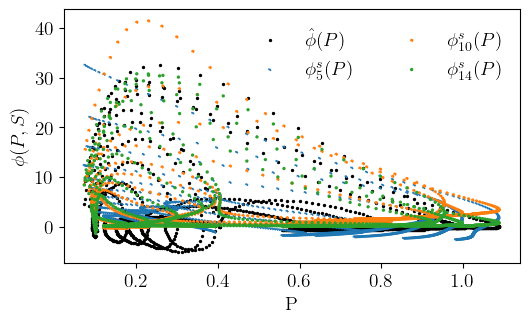

In [59]:
i=0
symb1=model_phi.predict(PTA_tf,choose_p)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
symb2=model_phi.predict(PTA_tf,choose_p_2)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
symb3=model_phi.predict(PTA_tf,choose_p_3)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p

# symb1=model_phi_phi.predict(s,choose,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
# symb2=model_phi_phi.predict(s,choose_2,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
# symb3=model_phi_phi.predict(s,choose_3,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p


plt.scatter(p_symb, phi,linewidth= 1,s=2, color='black', label='$\hat{\phi}(P)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], phi[L_symb*i:L_symb*(i+1)],linewidth=1, color='gray', label='$\hat{\phi}(S)$')

# plt.scatter(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.scatter(p_symb, symb1,linewidth=1, color=colors[0], s=2, linestyle=':', label='$\phi^s_5(P)$')
plt.scatter(p_symb, symb2,linewidth=1, color=colors[1],s=2, linestyle='--', label='$\phi^s_{10}(P)$')
plt.scatter(p_symb, symb3,linewidth=1, color=colors[2],s=2,linestyle='-.', label='$\phi^s_{14}(P)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_5(S)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{10}(S)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel('P', fontsize=14, color='black')
# plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color='gray', ha='center', transform=plt.gca().transAxes)


# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
# #plt.savefig('../Img/421/Result_phi_s.png')
# #plt.savefig('../Img/421/Result_phi_s.pdf')
# #plt.savefig('../Img/421/Result_phi_s.svg')
plt.show()


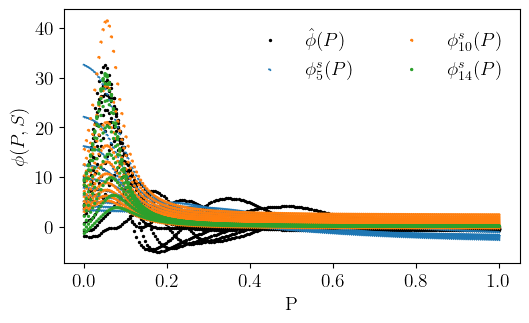

In [83]:
i=0
symb1=model_phi.predict(PTA_tf,choose_p)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
symb2=model_phi.predict(PTA_tf,choose_p_2)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
symb3=model_phi.predict(PTA_tf,choose_p_3)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p

# symb1=model_phi_phi.predict(s,choose,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
# symb2=model_phi_phi.predict(s,choose_2,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
# symb3=model_phi_phi.predict(s,choose_3,0])[...,0:1]*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p


plt.scatter(t_symb, phi,linewidth= 1,s=2, color='black', label='$\hat{\phi}(P)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], phi[L_symb*i:L_symb*(i+1)],linewidth=1, color='gray', label='$\hat{\phi}(S)$')

# plt.scatter(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.scatter(t_symb, symb1,linewidth=1, color=colors[0], s=2, linestyle=':', label='$\phi^s_5(P)$')
plt.scatter(t_symb, symb2,linewidth=1, color=colors[1],s=2, linestyle='--', label='$\phi^s_{10}(P)$')
plt.scatter(t_symb, symb3,linewidth=1, color=colors[2],s=2,linestyle='-.', label='$\phi^s_{14}(P)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_5(S)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{10}(S)$')
# plt.scatter(s_symb[L_symb*i:L_symb*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel('P', fontsize=14, color='black')
# plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color='gray', ha='center', transform=plt.gca().transAxes)


# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
# #plt.savefig('../Img/421/Result_phi_s.png')
# #plt.savefig('../Img/421/Result_phi_s.pdf')
# #plt.savefig('../Img/421/Result_phi_s.svg')
plt.show()


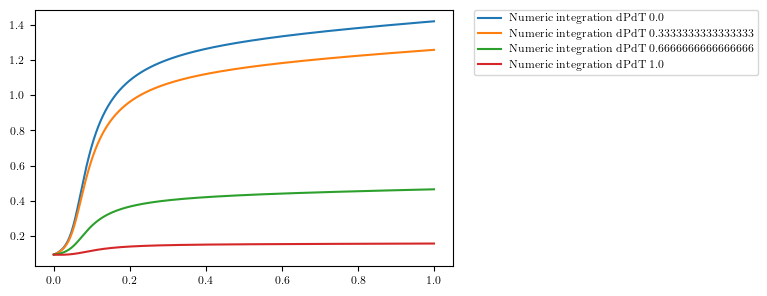

In [71]:
Nt=1000

# A_int=np.array([0,0.75, 1.25,2, 2.5,3,3.75])


for a_ in A:

    T_symb=np.zeros(Nt)
    P_symb=np.zeros(Nt)
    S_symb=np.zeros(Nt)


    dt=0.001

    T_symb[0]=0
    P_symb[0]=np.mean(P0) #Initial conditions
    # P_symb[0]=np.array(p[0]) #Initial conditions

    # S_symb[0]=np.array(s[0]) #Initial conditions
    for i in range(1,Nt):

        PTA=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PSA=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PHI_S=tf.exp(net(PSA, W_a, b_a))
        
        # PHI_S=tf.exp(net(PTA, W_phi, b_phi)[...,1:2])
        PHI=model_phi.predict(PTA,choose_p_3)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
        # REVISAAAAAR
        # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P_symb[i]=P_symb[i-1]+P_symb[i-1]*PHI*dt
        # S_symb[i]=S_symb[i-1]-S_symb[i-1]*P_symb[i-1]*PHI_S*dt
        T_symb[i]=T_symb[i-1]+dt


    plt.plot(T_symb, P_symb,  linestyle='-', label=f'Numeric integration dPdT {a_}')
    # plt.plot(T_symb, S_symb,  linestyle='--', label=f'Numeric integration dSdT {a_}')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

In [323]:
import pysindy as ps

# Supongamos que PT_tf tiene las columnas [P, T] y phi_scaled es un array
P = p_symb  # Primera columna (Presión)
T = t_symb  # Segunda columna (Temperatura)
min_cols_phi_p= tf.math.reduce_min(phi, axis=0)
max_cols_phi_p= tf.math.reduce_max(phi, axis=0)

phi_scaled = (phi-min_cols_phi_p)/(max_cols_phi_p-min_cols_phi_p)

phi_scaled = np.array(phi_scaled)[:,0] # Datos de phi_scaled

# Combinar P y T en una matriz de entrada
X = np.column_stack([P, T, a_symb])

In [358]:
# Configurar la librería de funciones
library = ps.PolynomialLibrary(degree=5)  # Hasta tercer grado polinomial
# library = ps.PolynomialLibrary(degree=5)  # Hasta tercer grado polinomial
# library = CustomLibrary(degree=5)  # Hasta tercer grado polinomial


# Crear el modelo SINDy con optimizador
model = ps.SINDy(feature_library=library, optimizer=ps.STLSQ(threshold=0.2))
# model = ps.SINDy(feature_library=library, optimizer=ps.STLSQ(threshold=0.005))

# Ajustar el modelo a los datos
model.fit(X, x_dot=phi_scaled)  # Aquí phi_scaled se interpreta como "derivadas" del sistema

# Imprimir la ecuación aprendida
model.print()

(x0)' = -0.191 1 + 10.972 x0 + 9.765 x1 + 0.485 x2 + -45.310 x0^2 + 4.011 x0 x1 + -18.915 x0 x2 + -152.874 x1^2 + 103.382 x1 x2 + -1.496 x2^2 + 75.277 x0^3 + 170.845 x0 x1^2 + -180.793 x0 x1 x2 + 31.307 x0 x2^2 + 21.605 x1^3 + 273.209 x1^2 x2 + -282.199 x1 x2^2 + -0.964 x2^3 + -60.783 x0^4 + 153.370 x0^2 x2^2 + 22.534 x0 x1^3 + -282.746 x0 x1^2 x2 + 167.471 x0 x1 x2^2 + 4.662 x0 x2^3 + 50.381 x1^4 + 178.775 x1 x2^3 + 18.911 x0^5 + -0.445 x0^4 x1 + 5.104 x0^4 x2 + -58.109 x0^3 x1^2 + 51.462 x0^3 x1 x2 + -75.309 x0^3 x2^2 + 61.770 x0^2 x1^2 x2 + 52.284 x0^2 x1 x2^2 + -177.653 x0^2 x2^3 + -57.046 x0 x1^4 + -85.222 x0 x1^3 x2 + 179.910 x0 x1^2 x2^2 + -62.671 x0 x1 x2^3 + -10.037 x1^5 + -32.092 x1^4 x2 + -142.172 x1^2 x2^3 + 0.140 x2^5


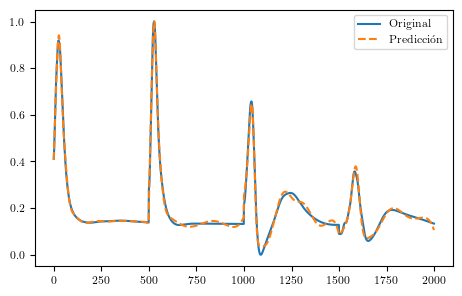

In [359]:
predicted_phi = model.predict(X)
plt.plot( phi_scaled, label="Original")
plt.plot( predicted_phi, label="Predicción", linestyle="dashed")
plt.legend()
plt.show()

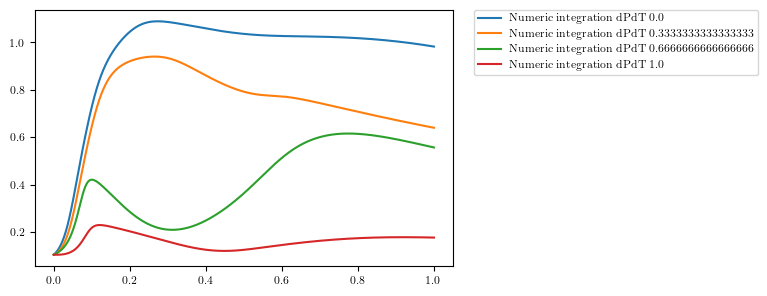

In [361]:
Nt=20000

# A_int=np.array([0,0.75, 1.25,2, 2.5,3,3.75])


for a_ in A:

    T_symb=np.zeros(Nt)
    P_symb=np.zeros(Nt)
    S_symb=np.zeros(Nt)


    dt=0.00005

    T_symb[0]=0
    P_symb[0]=np.mean(P0)+0.01 #Initial conditions
    # P_symb[0]=np.array(p[0]) #Initial conditions

    # S_symb[0]=np.array(s[0]) #Initial conditions
    for i in range(1,Nt):

        PTA=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PSA=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PHI_S=tf.exp(net(PSA, W_a, b_a))
        
        # PHI_S=tf.exp(net(PTA, W_phi, b_phi)[...,1:2])
        PHI=model.predict(PTA)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
        # REVISAAAAAR
        # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P_symb[i]=P_symb[i-1]+P_symb[i-1]*PHI*dt
        # S_symb[i]=S_symb[i-1]-S_symb[i-1]*P_symb[i-1]*PHI_S*dt
        T_symb[i]=T_symb[i-1]+dt


    plt.plot(T_symb, P_symb,  linestyle='-', label=f'Numeric integration dPdT {a_}')
    # plt.plot(T_symb, S_symb,  linestyle='--', label=f'Numeric integration dSdT {a_}')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

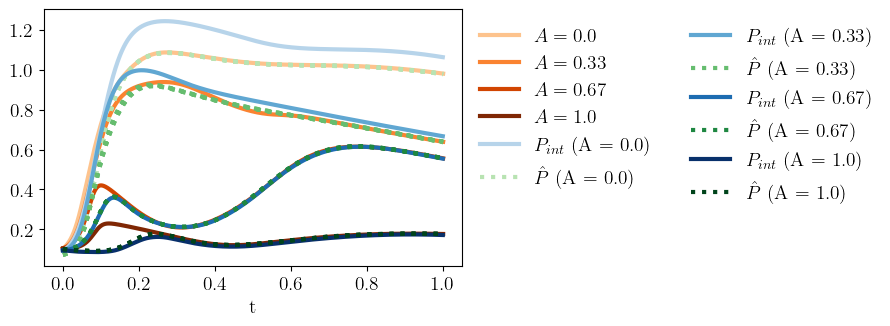

In [368]:

colors_p = plt.cm.Blues(np.linspace(0.3, 1, len(A)))
colors_s = plt.cm.Oranges(np.linspace(0.3, 1, len(A)))
colors_t = plt.cm.Greens(np.linspace(0.3, 1, len(A)))

Nt=20000

# A_int=np.array([0,0.75, 1.25,2, 2.5,3,3.75])


for idx, a_ in enumerate(A):


    T_symb=np.zeros(Nt)
    P_symb=np.zeros(Nt)
    S_symb=np.zeros(Nt)


    dt=0.00005

    T_symb[0]=0
    P_symb[0]=np.mean(P0)+0.01 #Initial conditions
    # P_symb[0]=np.array(p[0]) #Initial conditions

    # S_symb[0]=np.array(s[0]) #Initial conditions
    for i in range(1,Nt):

        PTA=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PSA=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PHI_S=tf.exp(net(PSA, W_a, b_a))
        
        # PHI_S=tf.exp(net(PTA, W_phi, b_phi)[...,1:2])
        PHI=model.predict(PTA)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
        # REVISAAAAAR
        # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P_symb[i]=P_symb[i-1]+P_symb[i-1]*PHI*dt
        # S_symb[i]=S_symb[i-1]-S_symb[i-1]*P_symb[i-1]*PHI_S*dt
        T_symb[i]=T_symb[i-1]+dt


    plt.plot(T_symb, P_symb, linewidth=3, linestyle='-', label=f'$A = {np.round(a_, 2)}$', color=colors_s[idx])

    # plt.plot(T_symb, S_symb,  linestyle='--', label=f'Numeric integration dSdT {a_}')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
# plt.show()

Nt=1000

for idx, a_ in enumerate(A):

    T_int=np.zeros(Nt)
    P_int=np.zeros(Nt)
    S_int=np.zeros(Nt)


    dt=0.001

    T_int[0]=0
    P_int[0]=np.mean(P0) #Initial conditions

    for i in range(1,Nt):

        PTA=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_int[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PHI_S=tf.exp(net(PSA, W_a, b_a))
        
        PHI=net(PTA, W_phi, b_phi)
        # REVISAAAAAR
        # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P_int[i]=P_int[i-1]+P_int[i-1]*PHI*dt
        # S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*PHI_S*dt
        T_int[i]=T_int[i-1]+dt


    plt.plot(T_int, P_int, linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
    # plt.plot(T_int, S_int,linewidth=3, linestyle='--', label='$S_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_s[idx])

    i=0
    plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx], label='$\hat{P}$'+f' (A = {np.round(A[idx], 2)})')

    for i in range(1,n[idx]):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx])




plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('t', fontsize=14)
# plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.tight_layout()
plt.savefig('../Img/600/Result_symb.png')
plt.savefig('../Img/600/Result_symb.pdf')
plt.savefig('../Img/600/Result_symb.svg')
plt.show()

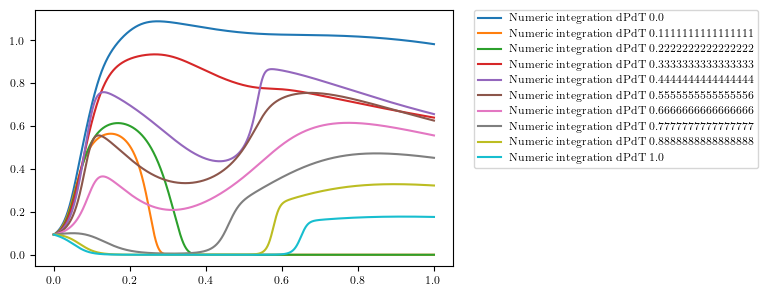

In [363]:
Nt=20000

A_int=np.linspace(0,1,10)

for a_ in A_int:

    T_symb=np.zeros(Nt)
    P_symb=np.zeros(Nt)
    S_symb=np.zeros(Nt)


    dt=0.00005

    T_symb[0]=0
    P_symb[0]=np.mean(P0) #Initial conditions
    # P_symb[0]=np.array(p[0]) #Initial conditions

    # S_symb[0]=np.array(s[0]) #Initial conditions
    for i in range(1,Nt):

        PTA=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PSA=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PHI_S=tf.exp(net(PSA, W_a, b_a))
        
        # PHI_S=tf.exp(net(PTA, W_phi, b_phi)[...,1:2])
        PHI=model.predict(PTA)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
        # REVISAAAAAR
        # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P_symb[i]=P_symb[i-1]+P_symb[i-1]*PHI*dt
        # S_symb[i]=S_symb[i-1]-S_symb[i-1]*P_symb[i-1]*PHI_S*dt
        T_symb[i]=T_symb[i-1]+dt


    plt.plot(T_symb, P_symb,  linestyle='-', label=f'Numeric integration dPdT {a_}')
    # plt.plot(T_symb, S_symb,  linestyle='--', label=f'Numeric integration dSdT {a_}')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

In [371]:
n

array([5, 6, 5, 3])

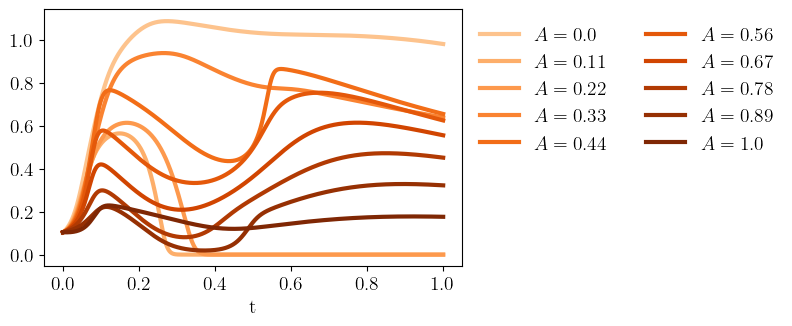

In [373]:

A_int=np.linspace(0,1,10)

colors_p = plt.cm.Blues(np.linspace(0.3, 1, len(A_int)))
colors_s = plt.cm.Oranges(np.linspace(0.3, 1, len(A_int)))
colors_t = plt.cm.Greens(np.linspace(0.3, 1, len(A_int)))

Nt=20000



for idx, a_ in enumerate(A_int):


    T_symb=np.zeros(Nt)
    P_symb=np.zeros(Nt)
    S_symb=np.zeros(Nt)


    dt=0.00005

    T_symb[0]=0
    P_symb[0]=np.mean(P0)+0.01 #Initial conditions
    # P_symb[0]=np.array(p[0]) #Initial conditions

    # S_symb[0]=np.array(s[0]) #Initial conditions
    for i in range(1,Nt):

        PTA=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PSA=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
        # PHI_S=tf.exp(net(PSA, W_a, b_a))
        
        # PHI_S=tf.exp(net(PTA, W_phi, b_phi)[...,1:2])
        PHI=model.predict(PTA)*(max_cols_phi_p-min_cols_phi_p)+min_cols_phi_p
        # REVISAAAAAR
        # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P_symb[i]=P_symb[i-1]+P_symb[i-1]*PHI*dt
        # S_symb[i]=S_symb[i-1]-S_symb[i-1]*P_symb[i-1]*PHI_S*dt
        T_symb[i]=T_symb[i-1]+dt


    plt.plot(T_symb, P_symb, linewidth=3, linestyle='-', label=f'$A = {np.round(a_, 2)}$', color=colors_s[idx])

    # plt.plot(T_symb, S_symb,  linestyle='--', label=f'Numeric integration dSdT {a_}')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
# plt.show()

# Nt=1000

# for idx, a_ in enumerate(A_int):

#     T_int=np.zeros(Nt)
#     P_int=np.zeros(Nt)
#     S_int=np.zeros(Nt)


#     dt=0.001

#     T_int[0]=0
#     P_int[0]=np.mean(P0) #Initial conditions

#     for i in range(1,Nt):

#         PTA=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_int[i-1].reshape([-1,1]), dtype=tf.float32), tf.convert_to_tensor(a_.reshape([-1,1]), dtype=tf.float32)],1)
#         # PHI_S=tf.exp(net(PSA, W_a, b_a))
        
#         PHI=net(PTA, W_phi, b_phi)
#         # REVISAAAAAR
#         # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
#         P_int[i]=P_int[i-1]+P_int[i-1]*PHI*dt
#         # S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*PHI_S*dt
#         T_int[i]=T_int[i-1]+dt


#     plt.plot(T_int, P_int, linewidth=3,linestyle='-', label='$P_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_p[idx])
#     # plt.plot(T_int, S_int,linewidth=3, linestyle='--', label='$S_{int}$'+f' (A = {np.round(a_, 2)})', color=colors_s[idx])


# for idx, a_ in enumerate(A):
#     i=0
#     plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx], label='$\hat{P}$'+f' (A = {np.round(A_int[idx], 2)})')

#     for i in range(1,n[idx]):
#         # Aquí puedes pasar el color seleccionado en cada iteración
#         # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
#         plt.plot(X_star_tf[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)][:,0],p[L_exp*(i + np.sum(n[:idx])):L_exp*((i + np.sum(n[:idx]))+1)],linewidth=3, linestyle=':',color=colors_t[idx])




plt.legend(fontsize=14, ncols=2, frameon=False, bbox_to_anchor=(1, 1))

plt.xlabel('t', fontsize=14)
# plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
# plt.tight_layout()
plt.savefig('../Img/600/Result_symb_2.png')
plt.savefig('../Img/600/Result_symb_2.pdf')
plt.savefig('../Img/600/Result_symb_2.svg')
plt.show()

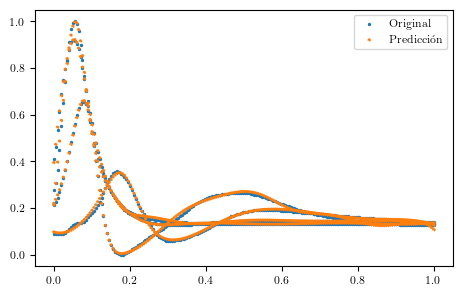

In [169]:
predicted_phi = model.predict(X)

# Comparar predicción con phi_scaled original
import matplotlib.pyplot as plt
plt.scatter(T, phi_scaled, s=2, label="Original")
plt.scatter(T, predicted_phi,s=2, label="Predicción", linestyle="dashed")
plt.legend()
plt.show()